# 画像分類

MNISTの分類を行う

In [1]:
from keras.datasets import mnist
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt
from skopt.plots import plot_convergence
from skopt import gp_minimize
from sklearn.model_selection import GridSearchCV
import pandas as pd

2023-12-25 04:20:18.717380: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-25 04:20:18.751233: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-25 04:20:18.751264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-25 04:20:18.752481: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-25 04:20:18.759047: I tensorflow/core/platform/cpu_feature_guar

In [2]:
## 複数の画像を受け取り、画像ごとに1次元化して返却する関数
def to1d(images: np.ndarray) -> np.ndarray:
    return images.reshape(images.shape[0], -1)

In [3]:
np.append(np.array([1,2,3]), np.array([4,2,3]))

array([1, 2, 3, 4, 2, 3])

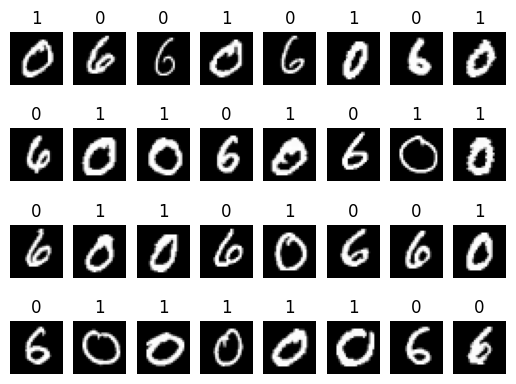

(300, 28, 28)


In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 単純のために使用する文字を制限する
p1 = 0
p2 = 6

# 文字数制限
train_n = 300
test_n = 1000

train_p1_index = np.where(y_train == p1)
train_p2_index = np.where(y_train == p2)
train_index = np.append(train_p1_index, train_p2_index)
train_index = np.sort(train_index)[:train_n]

test_p1_index = np.where(y_test == p1)
test_p2_index = np.where(y_test == p2)
test_index = np.append(test_p1_index, test_p2_index)
test_index = np.sort(test_index)[:test_n]

x_train = x_train[train_index]
y_train = y_train[train_index]
x_test = x_test[test_index]
y_test = y_test[test_index]

# p1 であれば1, p2であれば0というふうにデータを変換する
#print(y_train, y_test)
y_train = np.where(y_train == p1, 1, 0)
y_test = np.where(y_test == p1, 1, 0)
#print(y_train, y_test)

# 可視化
row, col = 4, 8
fig, ax = plt.subplots(row, col)
ax = ax.flatten()
for i, img_index in enumerate(range(0, row * col)):
    ax[i].imshow(x_train[img_index], cmap='gray')
    ax[i].set_title(y_train[img_index])
    ax[i].axis('off')
plt.show()

print(x_train.shape)
x_train = to1d(x_train)
x_test = to1d(x_test)

In [5]:
# XGBoost
# ちょっと重い

xg = XGBClassifier()

xg.fit(x_train, y_train)
predict_proba = xg.predict_proba(x_test)
predict = xg.predict(x_test)

In [6]:
print(predict, predict_proba)

[1 1 0 1 0 0 1 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 0 1 1 1 1 0
 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 0 1 0 0 1 1 0 0 0 1 1 0 1 1 1 0
 0 1 1 0 0 0 0 1 0 1 0 1 0 0 1 0 1 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 1 1 1
 0 0 1 1 0 1 1 0 0 0 1 1 1 0 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0 0 0 1 0 1 1 1 0
 0 0 1 1 0 0 1 1 0 1 1 0 0 0 0 0 1 1 0 1 0 0 1 1 1 1 1 0 1 0 0 1 1 0 1 0 1
 0 0 0 1 0 1 0 1 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1
 0 1 0 0 1 0 0 0 0 1 0 0 1 1 0 1 1 1 1 0 1 1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 1
 1 1 1 1 0 0 1 1 0 1 0 0 0 0 1 1 0 0 1 1 1 0 1 1 0 1 1 0 0 0 0 1 0 1 1 1 1
 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1
 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 0 1 1 0 1 1 0 0 1 0 1
 1 1 0 1 1 1 1 0 1 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 1 1 1 0
 1 1 1 0 1 0 0 0 0 1 1 1 0 1 1 0 1 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 1 0 1 0 1
 1 0 1 1 0 0 1 0 1 0 1 1 0 1 1 0 0 1 0 1 0 1 1 0 1 1 0 1 1 1 0 0 1 0 1 1 0
 1 1 1 0 0 0 0 1 0 0 1 1 

[[465  34]
 [ 13 488]]
0.953
0.9538346238317382
0.9529578118312474
[0.         0.06813627 1.        ] [0.        0.9740519 1.       ]


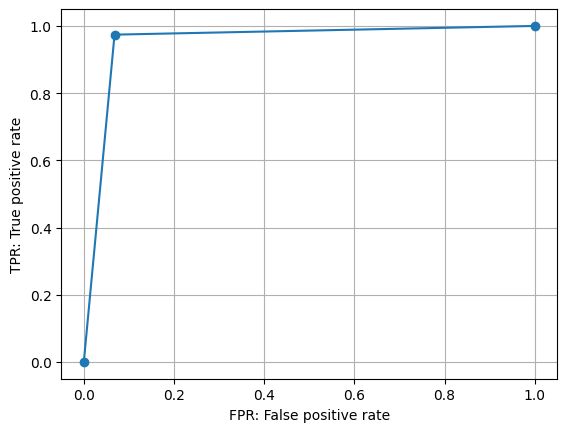

In [7]:
cm = confusion_matrix(y_test, predict)
acc = accuracy_score(y_test, predict)
pre = precision_score(y_test, predict, average='macro')
rec = recall_score(y_test, predict, average='macro')
fpr, tpr, thresholds = roc_curve(y_test, predict)

print(cm)
print(acc)
print(pre)
print(rec)

print(fpr, tpr)

plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
plt.show()


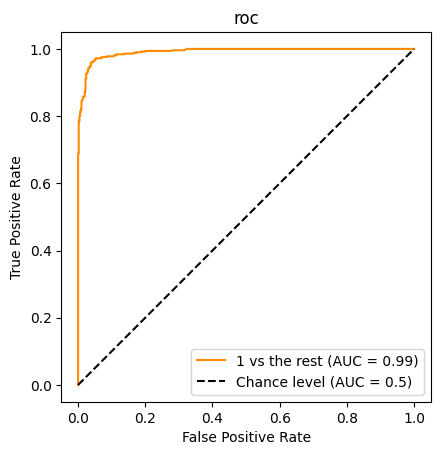

In [8]:
def labeling(y):
    if y == 0:
        return [1, 0]
    return [0, 1]
y_onehot_test =  np.array([labeling(y) for y in y_test])
y_onehot_train = np.array([labeling(y) for y in y_train])

import matplotlib.pyplot as plt

from sklearn.metrics import RocCurveDisplay

class_id = 1

RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    predict_proba[:, class_id],
    name=f"{class_id} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("roc")
plt.legend()
plt.show()